In [2]:
import pandas as pd
import numpy as np
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(rc={'figure.figsize':(10,6)})

In [4]:
#Read covid data
vaccinations = pd.read_csv('data/covid/owid-covid-latest.csv')
#Kosovo has changed its code in 2019
vaccinations.loc[vaccinations['iso_code']=='OWID_KOS','iso_code'] = 'XKX'
#Getting rid of continents and non-recongnised countries
vaccinations = vaccinations.loc[vaccinations['iso_code'].str.len()==3,]
#Filtering columns
vaccinations.set_index('iso_code', inplace = True)
vaccinations = vaccinations.loc[:,vaccinations.columns.str.contains('vaccin|gdp|reproduction', regex = True)]

In [5]:
vaccinations.columns

Index(['reproduction_rate', 'total_vaccinations', 'people_vaccinated',
       'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'gdp_per_capita'],
      dtype='object')

In [6]:
#Read population of all countries
population = pd.read_csv('data/countries data/API_SP.POP.TOTL_DS2_en_csv_v2_2163507.csv', skiprows=3)
#Change name of the important columns
population.rename(columns = {'Country Code': 'iso_code',
                            'Country Name': 'country',
                            '2019': 'population'}, inplace = True)
#Filtering columns
population.set_index('iso_code', inplace = True)
population = population[['country', 'population']]

#Adding Missing countries/territories in other df
population = population.append(pd.DataFrame(index = ['TWN'], 
                                            data = {'country': ['Taiwan'], 
                                                    'population': [23816775.0]}))

In [7]:
#Read class of each country
classification = pd.read_excel('data/countries data/CLASS.xls', sheet_name='List of economies', usecols = 'D,G', skiprows=[0,1,2,3,5], nrows=218)
classification.rename(columns = {'Code': 'iso_code',
                                'Income group': 'income_group'}, inplace = True)
classification.set_index('iso_code', inplace = True)

# Summary Tables

In [9]:
# Table per countries
df = pd.merge(left = population, right = classification, how = 'left', left_index = True, right_index = True)
df = pd.merge(left = df, right = vaccinations, how = 'left', left_index = True, right_index = True)
df = df[df['income_group'].notna()]
df['total_vaccinations'] = df['total_vaccinations'].fillna(value = 0)
df['total_vaccinations_per_hundred'] = df['total_vaccinations_per_hundred'].fillna(value = 0)

cols = ['country', 'population', 'gdp_per_capita', 'income_group', 'reproduction_rate', 'total_vaccinations', 'total_vaccinations_per_hundred']
df = df[cols]
df[df['reproduction_rate'].notna()].sort_values('reproduction_rate', ascending = False)[:5]

,country,population,gdp_per_capita,income_group,reproduction_rate,total_vaccinations,total_vaccinations_per_hundred
DJI,Djibouti,973560.0,2705.406,Lower middle income,1.99,0.0,0.00
MNG,Mongolia,3225167.0,11840.846,Lower middle income,1.74,300366.0,9.16
BGD,Bangladesh,163046161.0,3523.984,Lower middle income,1.62,5370431.0,3.26
PNG,Papua New Guinea,8776109.0,3823.194,Lower middle income,1.62,0.0,0.00
AZE,Azerbaijan,10023318.0,15847.419,Upper middle income,1.57,510420.0,5.03


In [48]:
# Aggregated table
df_summary = df.groupby('income_group').sum()[['population', 'total_vaccinations']]
df_summary['vaccine_percentage'] = df_summary['total_vaccinations']/df_summary['total_vaccinations'].sum()
df_summary['population_percentage'] = df_summary['population']/df_summary['population'].sum()
df_summary

,population,total_vaccinations,vaccine_percentage,population_percentage
income_group,,,,
High income,1.236079e+09,308088069.0,0.517606,0.161152
Low income,6.649578e+08,693803.0,0.001166,0.086693
Lower middle income,2.913363e+09,86105793.0,0.144663,0.379826
Upper middle income,2.855863e+09,200329862.0,0.336566,0.372329


# Drafts

## Draft 01

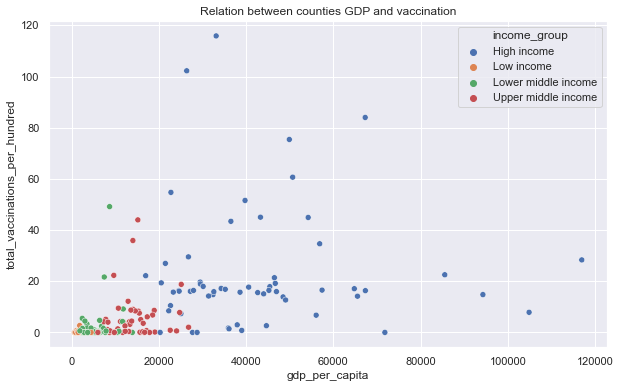

In [76]:
sns_plot = sns.scatterplot(x = 'gdp_per_capita', y = 'total_vaccinations_per_hundred', hue = 'income_group',  data = df).set_title('Relation between counties GDP and vaccination')
sns_plot.figure.savefig('draft01-01.png')

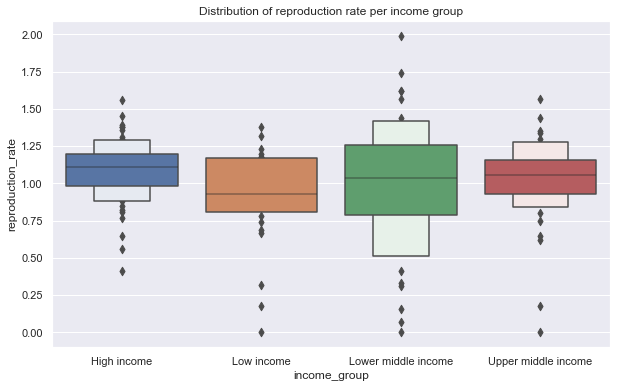

In [77]:
sns_plot = sns.boxenplot(x='income_group', y = 'reproduction_rate', data = df).set_title('Distribution of reproduction rate per income group')
sns_plot.figure.savefig('draft01-02.png')

# Draft 02

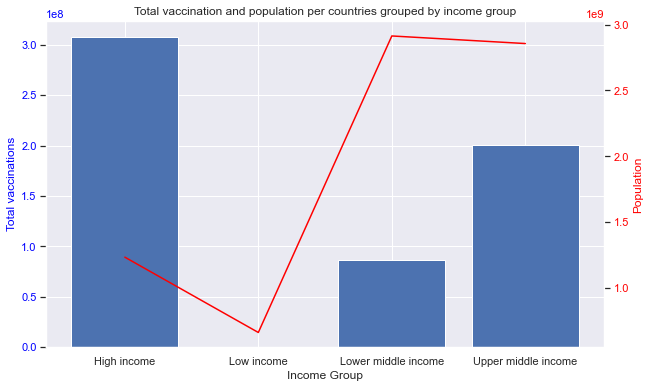

In [75]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(df_summary.index, df_summary['total_vaccinations'])

ax2 = ax1.twinx()
ax2.plot(df_summary.index, df_summary['population'], color = 'red')

ax1.set_xlabel('Income Group')
ax1.set_ylabel('Total vaccinations', color = 'blue')
ax2.set_ylabel('Population', color = 'red')

ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Total vaccination and population per countries grouped by income group')

#ax1.grid(False)
ax2.grid(False)
fig.savefig('draft02-01.png')

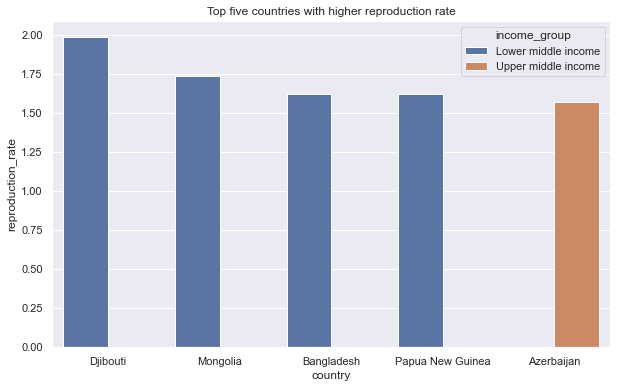

In [74]:
sns_plot = sns.barplot(x = 'country', y = 'reproduction_rate', hue = 'income_group', data = df[df['reproduction_rate'].notna()].sort_values('reproduction_rate', ascending = False)[:5]).set_title('Top five countries with higher reproduction rate')
sns_plot.figure.savefig('draft02-02.png')